# Initialize

## ASW session

In [98]:
import boto3

session = boto3.Session()
s3 = session.resource('s3')

## SageMaker Session

In [99]:
import sagemaker

sage_session = sagemaker.Session()

# Define Globals

In [100]:
# bucket name
bucket = 'aida-project'

# path for s3_input
s3_path = f"s3://{bucket}/"

## define source files
# TRAIN source file
train_source_path = 'team_remote'
train_source_name = 'title-train-princ4.csv'
#train_source_name = 'title-valid.csv'       # for testing; remove later


# VALID source file
valid_source_path = 'team_remote'
valid_source_name = 'title-valid-princ4.csv'
#valid_source_name = 'title-test.csv'       # for testing; remove later

# TEST source file
test_source_path = 'team_remote'
test_source_name = 'title-test-princ4.csv'

# output for result
output_path ='team_remote'
output_location = f'{s3_path}{output_path}/output'

In [101]:
print(output_location)

s3://aida-project/team_remote/output


In [102]:
# Create pointers to the S3 train and test datasets

from sagemaker import s3_input

# print(f"{s3_path}{train_source_path}/{train_source_name}")
# print(f"{s3_path}{valid_source_path}/{valid_source_name}")
# print(f"{s3_path}{test_source_path}/{test_source_name}")
s3_input_train = sagemaker.session.s3_input(s3_data=f"{s3_path}{train_source_path}/{train_source_name}", content_type="text/csv")
s3_input_valid = sagemaker.session.s3_input(s3_data=f"{s3_path}{valid_source_path}/{valid_source_name}", content_type="text/csv")
s3_input_test = sagemaker.session.s3_input(s3_data=f"{s3_path}{test_source_path}/{test_source_name}", content_type="text/csv")

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


In [103]:
role = sagemaker.get_execution_role()

# Define Model

In [104]:
# finde pre-defined models here:
# https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-algo-docker-registry-paths.html

# Create an XGBoost Estimator

# estimator call
# <ecr_path>/sagemaker-xgboost:1.2-1
    
ecr_path = "492215442770.dkr.ecr.eu-central-1.amazonaws.com"
xgboost_estimator = f"{ecr_path}/sagemaker-xgboost:1.0-1-cpu-py3"

# ecr_path = "664544806723.dkr.ecr.eu-central-1.amazonaws.com"
# knn_estimator = f"{ecr_path}/knn:latest"


In [105]:
xgboost = sagemaker.estimator.Estimator(xgboost_estimator,
                              role,
                              train_instance_count=1,
                              train_instance_type="ml.m5.4xlarge",
                              output_path=output_location,
                              sagemaker_session=sage_session,
                              base_job_name="JPC-xgboost")

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


In [106]:
# Select the your specific hyperparameters (Optional)
# https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost_hyperparameters.html
# https://github.com/dmlc/xgboost/blob/master/doc/parameter.rst#learning-task-parameters 

xgboost.set_hyperparameters(
    eta=.35,
    num_round=50,                     # required parameter!
    objective = 'reg:linear',
    )

In [107]:
from sagemaker.debugger import rule_configs, Rule, DebuggerHookConfig, CollectionConfig
from sagemaker.estimator import Estimator 
save_interval = 10
xgboost_debugger = Estimator( role=role, 
                             base_job_name="JPC-xgboost-debug", 
                             train_instance_count=1, 
                             train_instance_type='ml.m5.4xlarge', 
                             image_name=xgboost_estimator, 
                             #hyperparameters=hyperparameters, 
                             train_max_run=1800, 
                             debugger_hook_config=DebuggerHookConfig( s3_output_path=output_location, # Required 
                             collection_configs=[ CollectionConfig( name="feature_importance", parameters={ "save_interval": str(save_interval) } ), ], ), 
                              rules=[ Rule.sagemaker( rule_configs.loss_not_decreasing(), 
                                                     rule_parameters={ "collection_names": "metrics", "num_steps": str(save_interval * 2), }, ), ]
)
xgboost_debugger.set_hyperparameters(
    eta=.35,
    num_round=52,                     # required parameter!
    objective = 'reg:linear',
    )

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


## Fit Model

In [108]:
xgboost_debugger.fit({"train": s3_input_train, "validation": s3_input_valid}, wait=True)

2020-11-19 17:00:18 Starting - Starting the training job...
2020-11-19 17:00:20 Starting - Launching requested ML instances
********* Debugger Rule Status *********
*
*  LossNotDecreasing: InProgress        
*
****************************************
......
2020-11-19 17:01:46 Starting - Preparing the instances for training...
2020-11-19 17:02:06 Downloading - Downloading input data...
2020-11-19 17:02:47 Training - Training image download completed. Training in progress.INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value reg:linear to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[17:02:42]

In [109]:
#!pip install smdebug
from smdebug.trials import create_trial
s3_output_path = xgboost_debugger.latest_job_debugger_artifacts_path()
trial = create_trial(s3_output_path)

[2020-11-19 17:10:28.356 ip-172-16-29-248:27936 INFO s3_trial.py:42] Loading trial debug-output at path s3://aida-project/team_remote/output/JPC-xgboost-debug-2020-11-19-17-00-18-229/debug-output


In [110]:
trial.tensor

[2020-11-19 17:10:29.912 ip-172-16-29-248:27936 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2020-11-19 17:10:30.984 ip-172-16-29-248:27936 INFO trial.py:210] Loaded all steps


<bound method Trial.tensor of <smdebug.trials.s3_trial.S3Trial object at 0x7fbfc001c4a8>:(
    name=debug-output,
    path=s3://aida-project/team_remote/output/JPC-xgboost-debug-2020-11-19-17-00-18-229/debug-output/,
    steps=[0, 10, 20, 30, 40, 50],
    collections=['hyperparameters', 'metrics', 'predictions', 'labels', 'feature_importance', 'average_shap', 'full_shap', 'trees', 'default', 'losses'],
    tensor_names=['feature_importance/cover/f0', 'feature_importance/cover/f1', 'feature_importance/cover/f10', 'feature_importance/cover/f11', 'feature_importance/cover/f12', 'feature_importance/cover/f13', 'feature_importance/cover/f14', 'feature_importance/cover/f15', 'feature_importance/cover/f16', 'feature_importance/cover/f17', 'feature_importance/cover/f18', 'feature_importance/cover/f19', 'feature_importance/cover/f2', 'feature_importance/cover/f20', 'feature_importance/cover/f22', 'feature_importance/cover/f23', 'feature_importance/cover/f24', 'feature_importance/cover/f25', 'fe

In [111]:
trial.tensor_names()

['feature_importance/cover/f0',
 'feature_importance/cover/f1',
 'feature_importance/cover/f10',
 'feature_importance/cover/f11',
 'feature_importance/cover/f12',
 'feature_importance/cover/f13',
 'feature_importance/cover/f14',
 'feature_importance/cover/f15',
 'feature_importance/cover/f16',
 'feature_importance/cover/f17',
 'feature_importance/cover/f18',
 'feature_importance/cover/f19',
 'feature_importance/cover/f2',
 'feature_importance/cover/f20',
 'feature_importance/cover/f22',
 'feature_importance/cover/f23',
 'feature_importance/cover/f24',
 'feature_importance/cover/f25',
 'feature_importance/cover/f26',
 'feature_importance/cover/f27',
 'feature_importance/cover/f28',
 'feature_importance/cover/f29',
 'feature_importance/cover/f3',
 'feature_importance/cover/f30',
 'feature_importance/cover/f31',
 'feature_importance/cover/f32',
 'feature_importance/cover/f33',
 'feature_importance/cover/f34',
 'feature_importance/cover/f35',
 'feature_importance/cover/f36',
 'feature_impo

In [112]:
trial.tensor("feature_importance/cover/f0").values()

{10: array([0.04902172]),
 20: array([0.06575045]),
 30: array([0.0547872]),
 40: array([0.04975778]),
 50: array([0.01799525])}

In [113]:
liste = trial.tensor_names()

In [116]:
#[k for k in lst if 'ab' in k]
feature_importance_names = [k for k in liste if 'feature_importance/cover' in k]
feature_importance_col_names = ['isAdult', 'startYear', 'endYear', 'numVotes', 'Crime', 'Romance', 'Thriller', 'Adventure', 'Drama', 'War', 'Documentary', 'Reality-TV', 'Family', 'Fantasy', 'Game-Show', 'Adult', 'History', 'Mystery', 'Musical', 'Animation', 'Music', 'Film-Noir', 'shortGenre', 'Horror', 'Western', 'Biography', 'Comedy', 'Action', 'Sport', 'Talk-Show', 'Sci-Fi', 'News', 'movie', 'short', 'tvEpisode', 'tvMiniSeries', 'tvMovie', 'tvSeries', 'tvShort', 'tvSpecial', 'video', 'videoGame', 'nm0592314', 'nm10514069', 'nm11131030', 'nm11131593', 'nm1915152', 'nm2124199', 'nm2299581', 'nm2699546', 'nm3816718', 'nm4837590', 'nm5181169', 'nm5511980', 'nm6135542', 'nm6419589', 'nm7155068', 'nm7702567', 'nm8062068', 'nm8079243', 'nm8269207', 'nm8409754', 'nm8641187', 'nm8688464', 'nm8713978', 'nm8741892', 'nm9002892', 'nm9099684', 'nm9099685', 'nm9177141', 'nm9325202', 'nm9354107', 'distinct languages', 'distinct regions']
print(feature_importance_names)

['feature_importance/cover/f0', 'feature_importance/cover/f1', 'feature_importance/cover/f10', 'feature_importance/cover/f11', 'feature_importance/cover/f12', 'feature_importance/cover/f13', 'feature_importance/cover/f14', 'feature_importance/cover/f15', 'feature_importance/cover/f16', 'feature_importance/cover/f17', 'feature_importance/cover/f18', 'feature_importance/cover/f19', 'feature_importance/cover/f2', 'feature_importance/cover/f20', 'feature_importance/cover/f22', 'feature_importance/cover/f23', 'feature_importance/cover/f24', 'feature_importance/cover/f25', 'feature_importance/cover/f26', 'feature_importance/cover/f27', 'feature_importance/cover/f28', 'feature_importance/cover/f29', 'feature_importance/cover/f3', 'feature_importance/cover/f30', 'feature_importance/cover/f31', 'feature_importance/cover/f32', 'feature_importance/cover/f33', 'feature_importance/cover/f34', 'feature_importance/cover/f35', 'feature_importance/cover/f36', 'feature_importance/cover/f37', 'feature_im

In [117]:
feat_dict_10={}
feat_dict_50={}
for i,f in enumerate(feature_importance_names):
    index=int(f.split('f')[2])
    print(feature_importance_col_names[i],"\t\t",end='')

    
    try:
        feat_dict_10[feature_importance_col_names[index]]=trial.tensor(f).values()[10][0]
    except:
        feat_dict_10[feature_importance_col_names[index]]=0
    #print(f,index)
print(feat_dict_10)
print(30*'*')
print()
for i,f in enumerate(feature_importance_names):
    index=int(f.split('f')[2])
    try:
        feat_dict_50[feature_importance_col_names[index]]=trial.tensor(f).values()[50][0]
    except:
        feat_dict_50[feature_importance_col_names[index]]=0
   
print(feat_dict_50)

isAdult 		startYear 		endYear 		numVotes 		Crime 		Romance 		Thriller 		Adventure 		Drama 		War 		Documentary 		Reality-TV 		Family 		Fantasy 		Game-Show 		Adult 		History 		Mystery 		Musical 		Animation 		Music 		Film-Noir 		shortGenre 		Horror 		Western 		Biography 		Comedy 		Action 		Sport 		Talk-Show 		Sci-Fi 		News 		movie 		short 		tvEpisode 		tvMiniSeries 		tvMovie 		tvSeries 		tvShort 		tvSpecial 		video 		videoGame 		nm0592314 		nm10514069 		nm11131030 		nm11131593 		nm1915152 		nm2124199 		nm2299581 		nm2699546 		nm3816718 		{'isAdult': 0.04902172450760012, 'startYear': 0.007731743678272502, 'Documentary': 0.020954070611763607, 'Reality-TV': 0.024340919937262895, 'Family': 0.002816347625729448, 'Fantasy': 0.014046750999490027, 'Game-Show': 0.022368419586286808, 'Adult': 0.0001551272228130691, 'History': 0.07654415411172315, 'Mystery': 0.0019654479604704414, 'Musical': 0.0023012229271350006, 'Animation': 0.00846598415249249, 'endYear': 0.03043580177121961, 'Music': 0.013500729

In [118]:
feat_weight_dict={}
for i,f in enumerate(feature_importance_weight):
    print(feature_importance_col_names[i],"\t\t",end='')
    print(trial.tensor(f).values())
    #print(trial.tensor(f).values()[40][0])
    feat_weight_dict[feature_importance_col_names[i]]=trial.tensor(f).values()[50][0]
    #break
#print(feat_weight_dict)

isAdult 		{10: array([0.00441176]), 20: array([0.00386997]), 30: array([0.0031463]), 40: array([0.00361591]), 50: array([0.00435949])}
startYear 		{0: array([0.23728814]), 10: array([0.21029412]), 20: array([0.20897833]), 30: array([0.19087572]), 40: array([0.19284853]), 50: array([0.19450034])}
endYear 		{0: array([0.05084746]), 10: array([0.03382353]), 20: array([0.02399381]), 30: array([0.02412166]), 40: array([0.02290076]), 50: array([0.02146211])}
numVotes 		{0: array([0.05084746]), 10: array([0.02205882]), 20: array([0.02399381]), 30: array([0.02149974]), 40: array([0.01888309]), 50: array([0.01777331])}
Crime 		{10: array([0.01323529]), 20: array([0.01547988]), 30: array([0.01835343]), 40: array([0.01807955]), 50: array([0.01810865])}
Romance 		{10: array([0.00441176]), 20: array([0.00541796]), 30: array([0.00734137]), 40: array([0.00924066]), 50: array([0.01006036])}
Thriller 		{0: array([0.01694915]), 10: array([0.00735294]), 20: array([0.00619195]), 30: array([0.00629261]), 4

TensorUnavailable: Tensor feature_importance/weight/f74 was not saved.

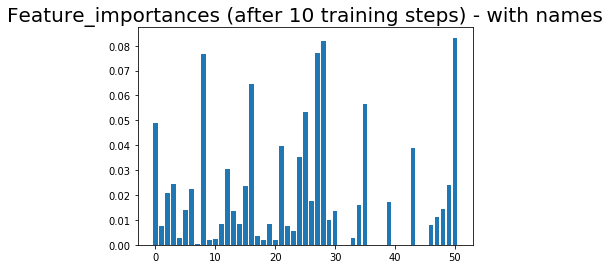

Text(0.5, 1.0, 'Feature_importances (after 50 training steps) - with names')

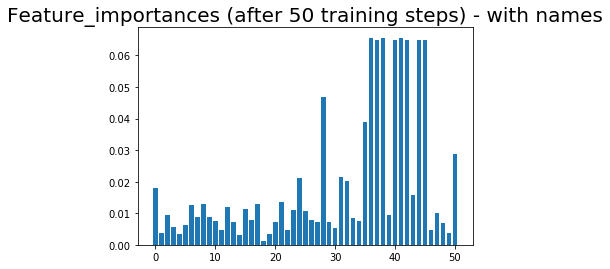

In [119]:
import matplotlib.pyplot as plt
plt.bar(range(len(feat_dict_10)),list(feat_dict_10.values()))
plt.title("Feature_importances (after 10 training steps) - with names", fontsize=20)
plt.show()
plt.bar(range(len(feat_dict_50)),list(feat_dict_50.values()))
plt.title("Feature_importances (after 50 training steps) - with names", fontsize=20)

Text(0.5, 1.0, 'Feature_importances_weight')

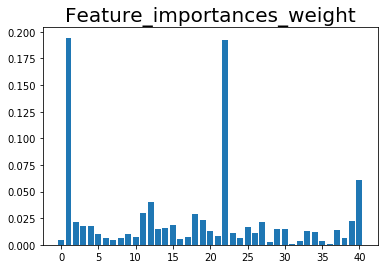

In [120]:
plt.bar(range(len(feat_weight_dict)),list(feat_weight_dict.values()))
plt.title("Feature_importances_weight", fontsize=20)

In [121]:
import pandas as pd




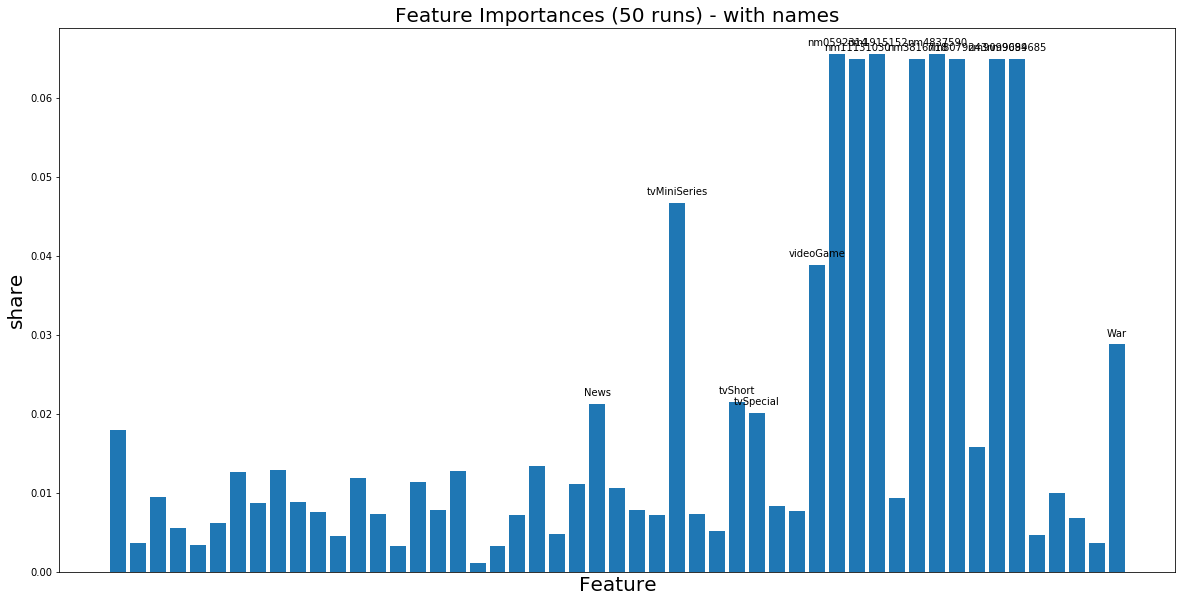

In [123]:
from datetime import datetime

now = datetime.now() # current date and time
time = now.strftime("%m-%d-%Y-%H-%M-%S")
#print(time)

dict = feat_dict_50

fig,ax = plt.subplots(figsize=(20,10))

#pd.DataFrame(feat_dict, index=['quantity']).plot(kind='bar',ax=ax,use_index=False, legend=False,width=1.4)
plt.bar(*zip(*dict.items()))
plt.title('Feature Importances (50 runs) - with names', fontsize=20)
plt.xlabel('Feature', fontsize=20)
plt.ylabel('share', fontsize=20)
plt.xticks(ticks=[])
threshold=0.02
pad=0.001
i=0
for k,v in dict.items():
    if v > threshold:
        ax.text(i,v+pad,k.replace(" ","\n"),horizontalalignment='center',fontsize=10)
    #reak
    i +=1
#plt.xlim([0,10])
#plt.ylim([0,10])
#plt.plot([0,10],[0,10], c='red')

#plt.show()
save_it=True
if save_it == True:
    filename='Feature_importance_princ-'+time
    plt.savefig(filename, dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait')
plt.show()

In [89]:
sum=0
for k,v in feat_dict.items():
    sum=sum+v
print(sum)

isAdult 0.051870616709514795


# Deploy Model

## Deploy

In [76]:
# Deploy  model to an endpoint

xgb_predictor = xgboost.deploy(
    initial_instance_count = 1, 
    instance_type = 'ml.t2.medium')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


-----------------!

## Configure Predictor

In [77]:
# Configure the predictor's serializer and deserializer

# INSERT CODE HERE

from sagemaker.predictor import csv_serializer, json_deserializer

xgb_predictor.content_type = "text/csv"
xgb_predictor.serializer = csv_serializer
xgb_predictor.deserializer = json_deserializer

# Display Endpoint

In [78]:
xgb_predictor.endpoint

'JPC-xgboost-2020-11-18-14-16-01-550'

# Prediction

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000


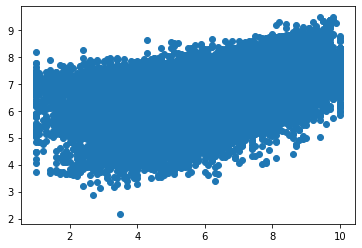

In [80]:
# carefully just one prediction
import pandas as pd
import matplotlib.pyplot as plt

col_names = ['averageRating', 'isAdult', 'startYear', 'endYear', 'numVotes', 'Crime', 'Romance', 'Thriller', 'Adventure', 'Drama', 'War', 'Documentary', 'Reality-TV', 'Family', 'Fantasy', 'Game-Show', 'Adult', 'History', 'Mystery', 'Musical', 'Animation', 'Music', 'Film-Noir', 'shortGenre', 'Horror', 'Western', 'Biography', 'Comedy', 'Action', 'Sport', 'Talk-Show', 'Sci-Fi', 'News', 'movie', 'short', 'tvEpisode', 'tvMiniSeries', 'tvMovie', 'tvSeries', 'tvShort', 'tvSpecial', 'video', 'videoGame', 'distinct languages', 'distinct regions']
test = pd.read_csv(f"{s3_path}{test_source_path}/{test_source_name}", header=0, index_col=False, names=col_names)
prediction=[]
for i in range(test.shape[0]):
    prediction.append(xgb_predictor.predict(test.iloc[i, 1:]))
    if i % 1000 == 0:
        print(i)
    #     print(prediction)
    #     print(test.iloc[i,0])
#print(prediction) 

plt.scatter(test.iloc[:,0], prediction)


11-18-2020-14-56-36


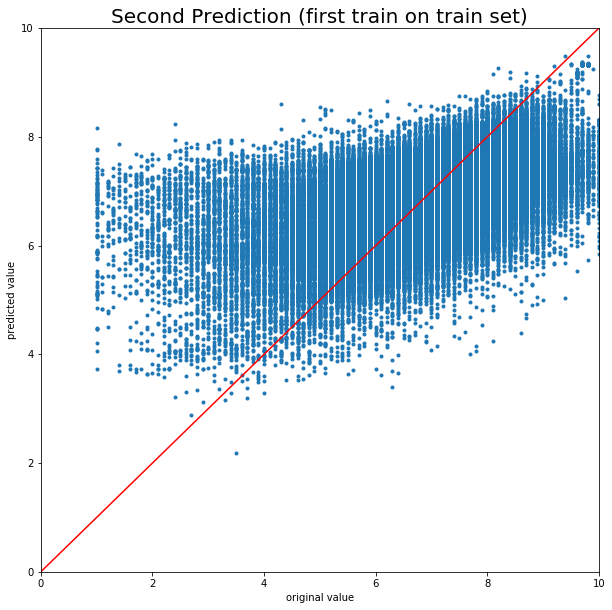

In [88]:
from datetime import datetime

now = datetime.now() # current date and time
time = now.strftime("%m-%d-%Y-%H-%M-%S")
print(time)



fig = plt.subplots(figsize=(10,10))
plt.scatter(test.iloc[:,0], prediction,marker='.')
plt.title('Second Prediction (first train on train set)', fontsize=20)
plt.xlabel('original value')
plt.ylabel('predicted value')
plt.xlim([0,10])
plt.ylim([0,10])
plt.plot([0,10],[0,10], c='red')

#plt.show()
filename='Prediction-'+time
plt.savefig(filename, dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait')


11-18-2020-14-55-10
